In [1]:
#download data links:
#https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 
#https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip

## Part 1
Pre-trained-Models with PyTorch

In [56]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
from tqdm import tqdm
torch.manual_seed(0)

In [3]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

In [5]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        #directory="/home/wsuser/work"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(positive)
        negative_file_path=os.path.join(negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


In [6]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:

In [41]:
model=models.resnet18()

<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.

In [42]:
for param in model.parameters():
    param.requires_grad=False

<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.

In [43]:
model.fc=nn.Linear(512,2)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
criterion = nn.CrossEntropyLoss()
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=550)
validation_loader=torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=150)

In [53]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.002)


In [59]:
n_epochs=5
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
device='cuda'
start_time = time.time()
#n_epochs
model.to(device)
criterion=criterion.to(device)
for epoch in range(n_epochs):
    batch=0
    print(f"{epoch}. Epoch starting... ")
    for x, y in tqdm(train_loader):
             
        model.train()
        x, y = x.to(device), y.to(device)
        #clear gradient 
        optimizer.zero_grad()
       
        #make a prediction 
        z=model(x)
        
        # calculate loss 
        loss=criterion(z,y)
       
        # calculate gradients of parameters 
        loss.backward()
        
        # update parameters 
        optimizer.step()
        loss_list.append(loss.data)
        batch+=1
    correct=0
    for x_test, y_test in validation_loader:
        # set model to eval 
        model.eval()
        x_test, y_test = x_test.to(device), y_test.to(device)
        #make a prediction 
        z=model(x_test)
        #find max 
        _,yhat=torch.max(z.data,1)
        

        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
        correct+=(yhat==y_test).sum().item()
   
    accuracy=correct/N_test
    accuracy_list.append(accuracy)   
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

end_time = time.time()
print(f"Training complete in: {(end_time - start_time) / 60:.2f} minutes")

0. Epoch starting... 


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [03:14<00:00,  3.54s/it]


Epoch 1/5, Loss: 0.09871520847082138, Accuracy: 95.58%
1. Epoch starting... 


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [04:23<00:00,  4.80s/it]


Epoch 2/5, Loss: 0.08789253979921341, Accuracy: 96.04%
2. Epoch starting... 


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [03:54<00:00,  4.26s/it]


Epoch 3/5, Loss: 0.07948029786348343, Accuracy: 96.39%
3. Epoch starting... 


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [04:01<00:00,  4.39s/it]


Epoch 4/5, Loss: 0.07279909402132034, Accuracy: 96.80%
4. Epoch starting... 


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [03:46<00:00,  4.11s/it]


Epoch 5/5, Loss: 0.06735493242740631, Accuracy: 96.87%
Training complete in: 26.04 minutes


In [60]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model.pt') # Save

In [61]:
model = torch.jit.load('model.pt')
model.eval()

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=BasicBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
    )
    (1): RecursiveScriptModule(
      original_name=BasicBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule(original_name=Conv2d)

In [62]:
accuracy

0.9687

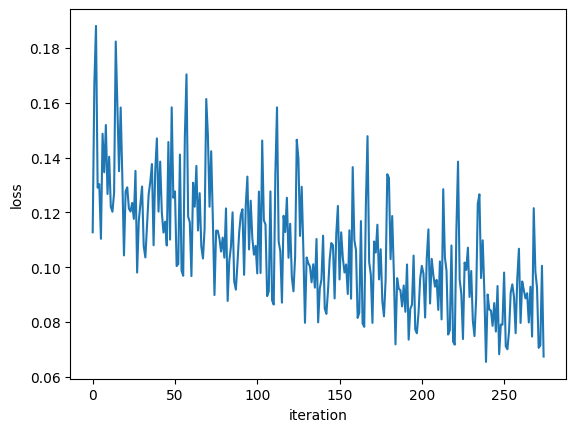

In [66]:
loss_list_cpu=[]
for loss in loss_list:
    loss_list_cpu.append(loss.cpu())
    
plt.plot(loss_list_cpu)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [68]:
missClassified=[]
count=0
for x_test, y_test in validation_loader:
        print(count)
        x_test, y_test = x_test.to(device), y_test.to(device)
        # set model to eval 
        #make a prediction 
        z=model(x_test)
        
        #find max 
        _,yhat=torch.max(z.data,1)
        for x,y_real,y_pred in zip(x_test.cpu(),y_test.cpu(),yhat):
            
            if y_real!=y_pred:
                missClassified.append([x,y_real,y_pred,count])
            count+=1
            if len(missClassified)==5:
                break
        if len(missClassified)==5:
                break         

0


In [69]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy(),cmap="gray")

Samble:30, Predict value: 0, Actual value: 1 


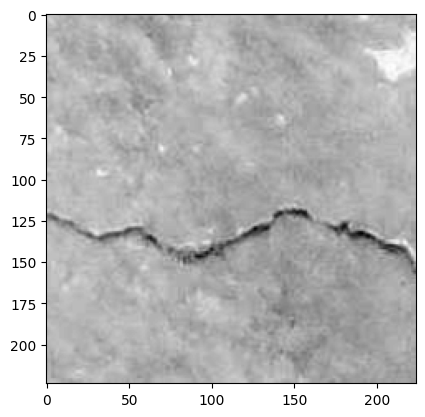

Samble:34, Predict value: 0, Actual value: 1 


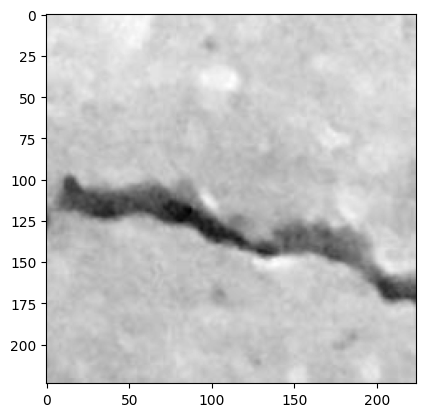

Samble:121, Predict value: 1, Actual value: 0 


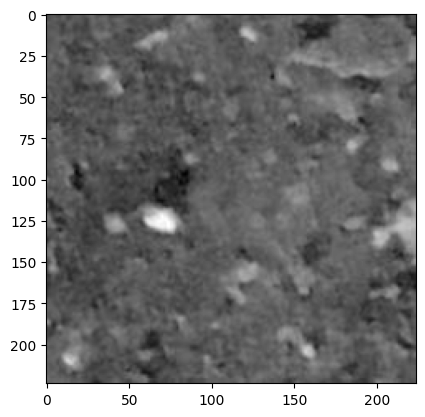

Samble:123, Predict value: 1, Actual value: 0 


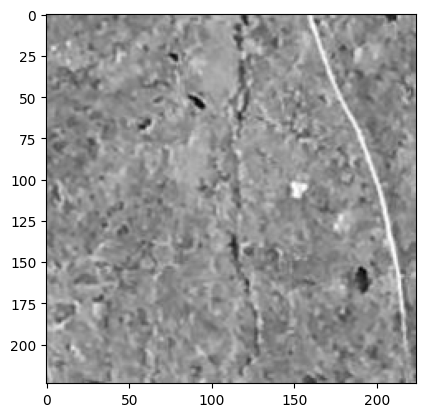

In [71]:
for samples in missClassified[:4]:
    x,y_real,y_pred,count =samples
    show_data(x)
    print(f"Samble:{count}, Predict value: {y_pred}, Actual value: {y_real} ")
    plt.show()